# Stock Price Prediction - Data Exploration

This notebook explores the stock data and demonstrates the preprocessing pipeline before model training.

In [13]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import config
from data.data_loader import StockDataLoader
from data.preprocessor import StockPreprocessor
from utils.visualization import StockVisualization

# Initialize visualization object
viz = StockVisualization()

plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading and Basic Information

In [14]:
# Load stock data
loader = StockDataLoader(symbols=config.stocks, period="2y")
data = loader.get_combined_data()

print(f"Dataset shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Symbols: {data['symbol'].unique()}")
print(f"\nColumns: {list(data.columns)}")

Fetching data for SPY
Fetching data for QQQ
Fetching data for AAPL
Fetching data for MSFT
Fetching data for GOOGL
Fetching data for TSLA
Successfully loaded data for 6 symbols
Dataset shape: (3012, 9)
Date range: 0 to 3011
Symbols: ['SPY' 'QQQ' 'AAPL' 'MSFT' 'GOOGL' 'TSLA']

Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'capital gains', 'symbol']


In [15]:
# Basic statistics
data.describe()

,open,high,low,close,volume,dividends,stock splits,capital gains
count,3012.000000,3012.000000,3012.000000,3012.000000,3.012000e+03,3012.000000,3012.0,1004.0
mean,337.324328,340.467641,334.075943,337.426361,5.327739e+07,0.009597,0.0,0.0
std,146.233137,146.494786,145.739849,146.188102,3.493688e+07,0.105931,0.0,0.0
min,122.147440,122.574876,119.493359,121.441673,7.164500e+06,0.000000,0.0,0.0
25%,192.153302,194.635512,190.120283,192.128281,2.682438e+07,0.000000,0.0,0.0
50%,345.594574,352.883001,340.367863,346.229996,4.449485e+07,0.000000,0.0,0.0
75%,456.183273,461.689995,452.547178,457.288116,6.845620e+07,0.000000,0.0,0.0
max,644.909973,646.190002,642.690002,644.890015,3.186799e+08,1.966000,0.0,0.0


In [16]:
# Check for missing values
missing_data = data.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

Missing values per column:
capital gains    2008
dtype: int64


## 2. Stock Price Visualization

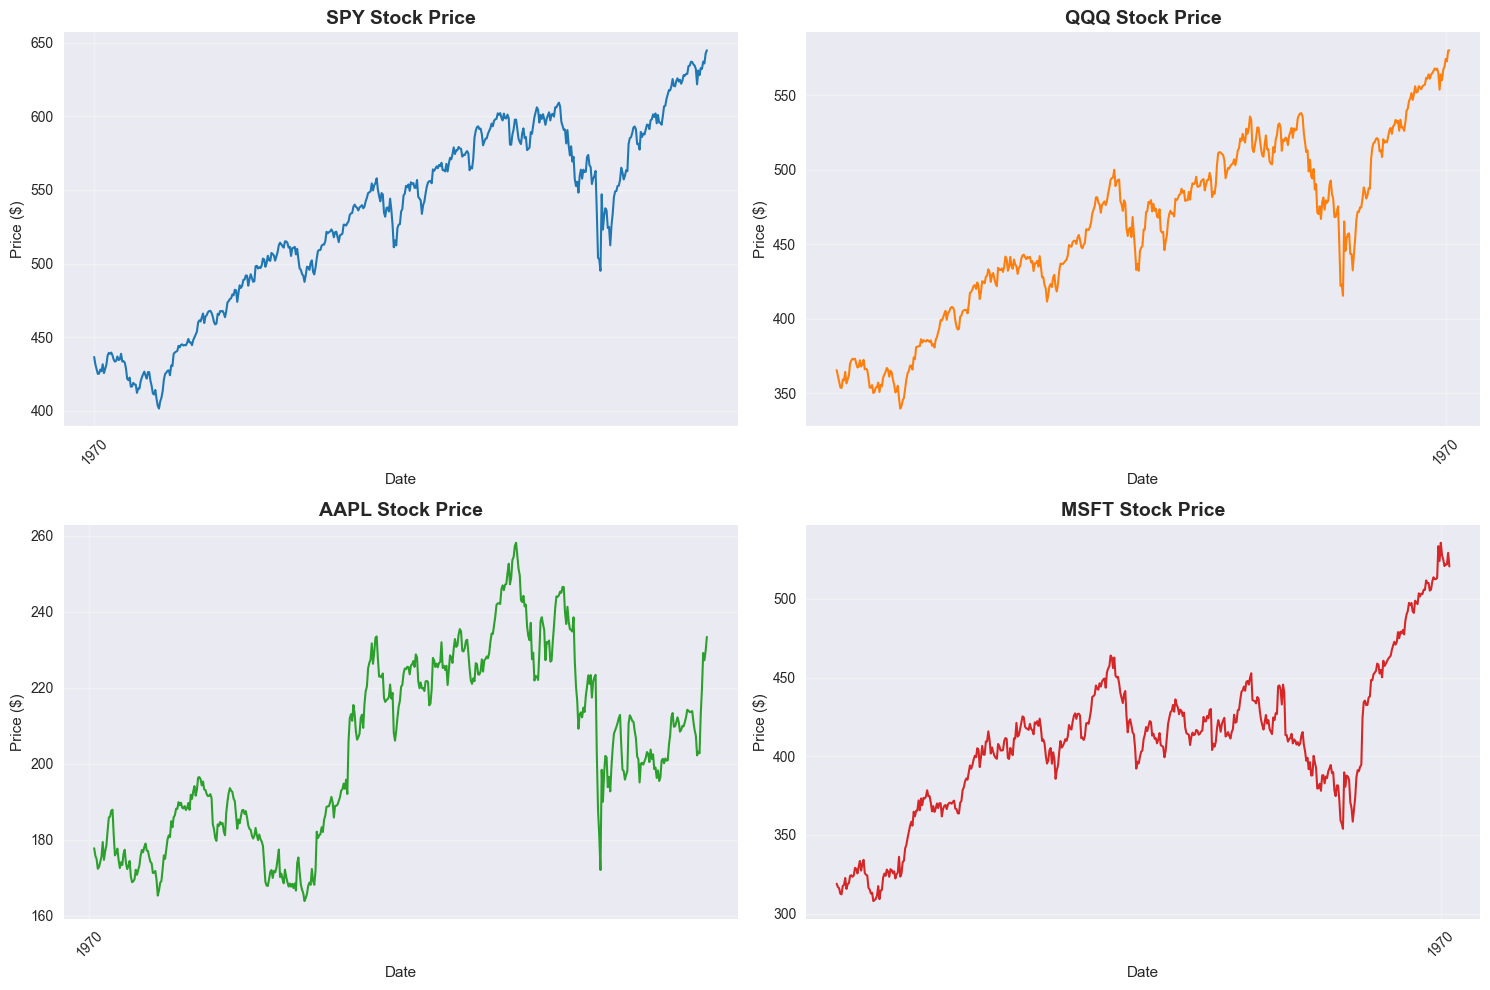

In [17]:
# Plot stock prices
viz.plot_stock_prices(data, symbols=config.stocks)

## 3. Data Analysis

In [18]:
# Data analysis
print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

Dataset shape: (3012, 9)
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'capital gains', 'symbol']


## 4. Feature Correlation Analysis

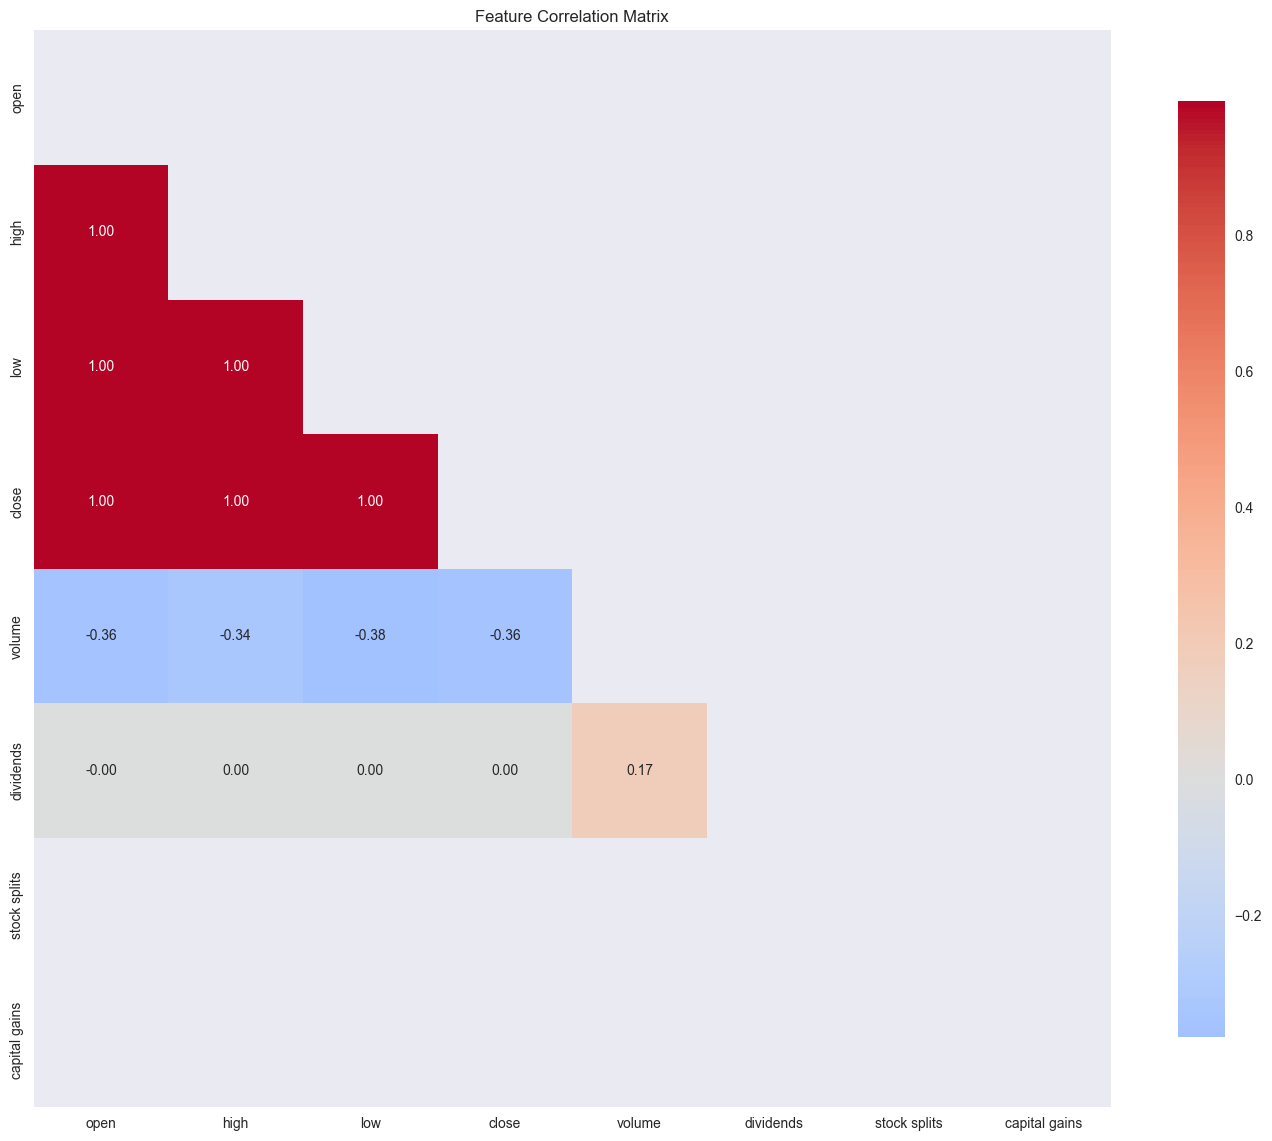

In [19]:
# Select numeric features for correlation analysis
single_data = data[data["symbol"] == config.stocks[0]].copy()
numeric_features = single_data.select_dtypes(include=[np.number]).columns
numeric_features = [col for col in numeric_features if col not in ["symbol"]]

# Plot correlation matrix
viz.plot_correlation_matrix(single_data[numeric_features], figsize=(14, 12))

## 5. Price Returns Analysis

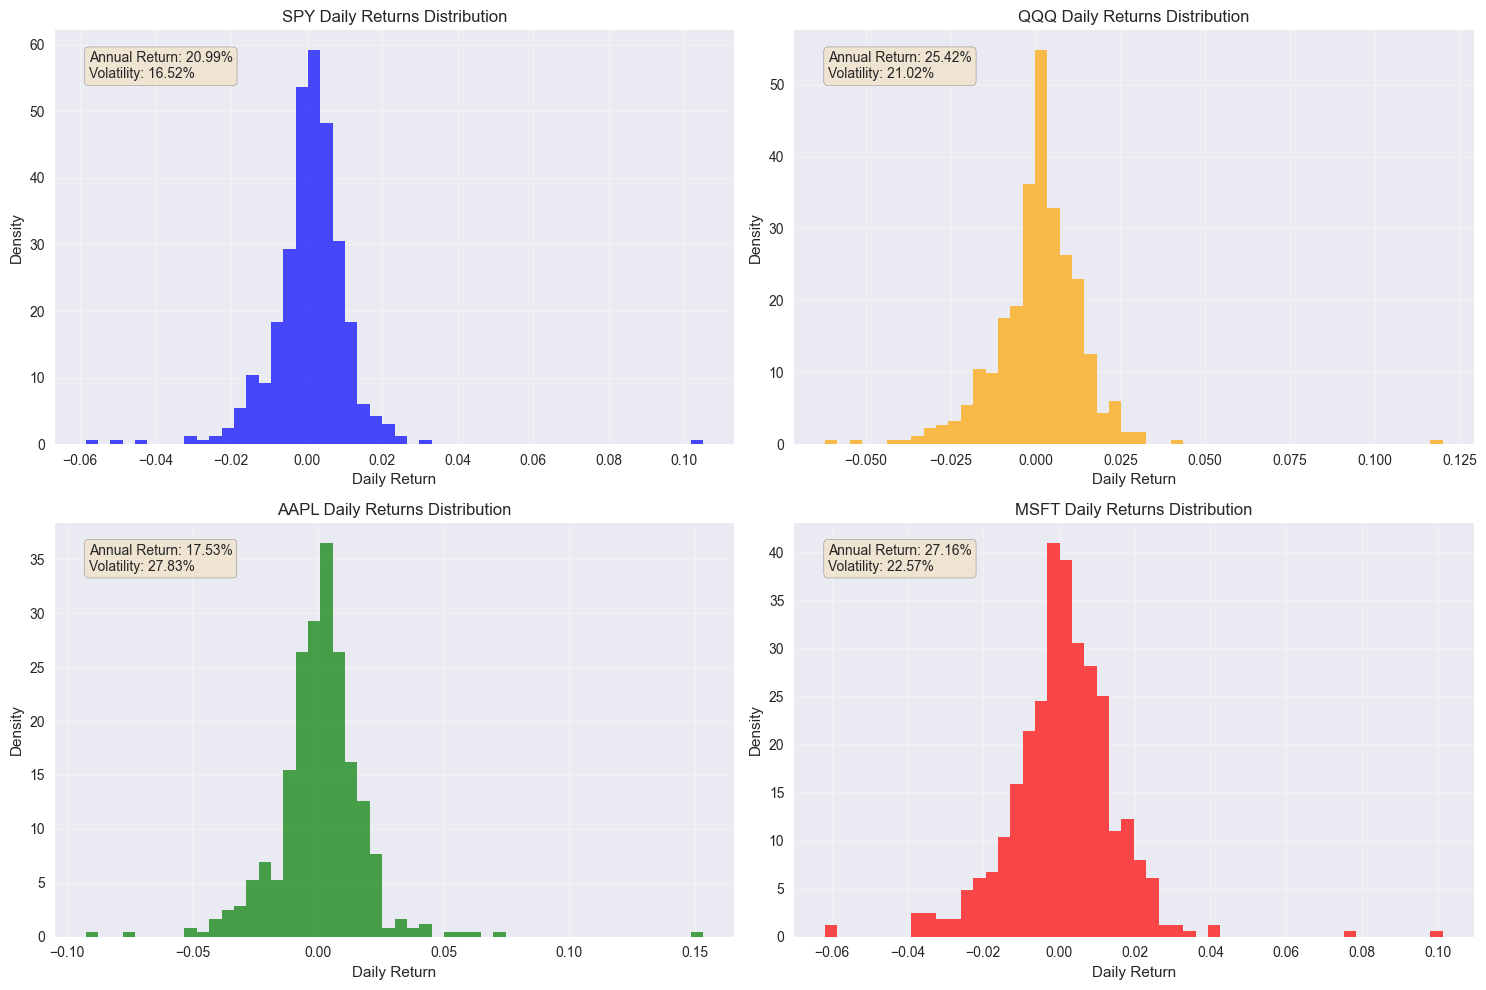

In [20]:
# Calculate daily returns for each stock
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

symbols = data["symbol"].unique()[:4]
colors = ["blue", "orange", "green", "red"]

for i, symbol in enumerate(symbols):
    symbol_data = data[data["symbol"] == symbol].copy()
    returns = symbol_data["close"].pct_change().dropna()

    axes[i].hist(returns, bins=50, alpha=0.7, color=colors[i], density=True)
    axes[i].set_title(f"{symbol} Daily Returns Distribution")
    axes[i].set_xlabel("Daily Return")
    axes[i].set_ylabel("Density")
    axes[i].grid(True, alpha=0.3)

    # Add statistics
    mean_return = returns.mean() * 252  # Annualized
    volatility = returns.std() * np.sqrt(252)  # Annualized
    axes[i].text(
        0.05,
        0.95,
        f"Annual Return: {mean_return:.2%}\nVolatility: {volatility:.2%}",
        transform=axes[i].transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

plt.tight_layout()
plt.show()

## 6. Volatility Analysis

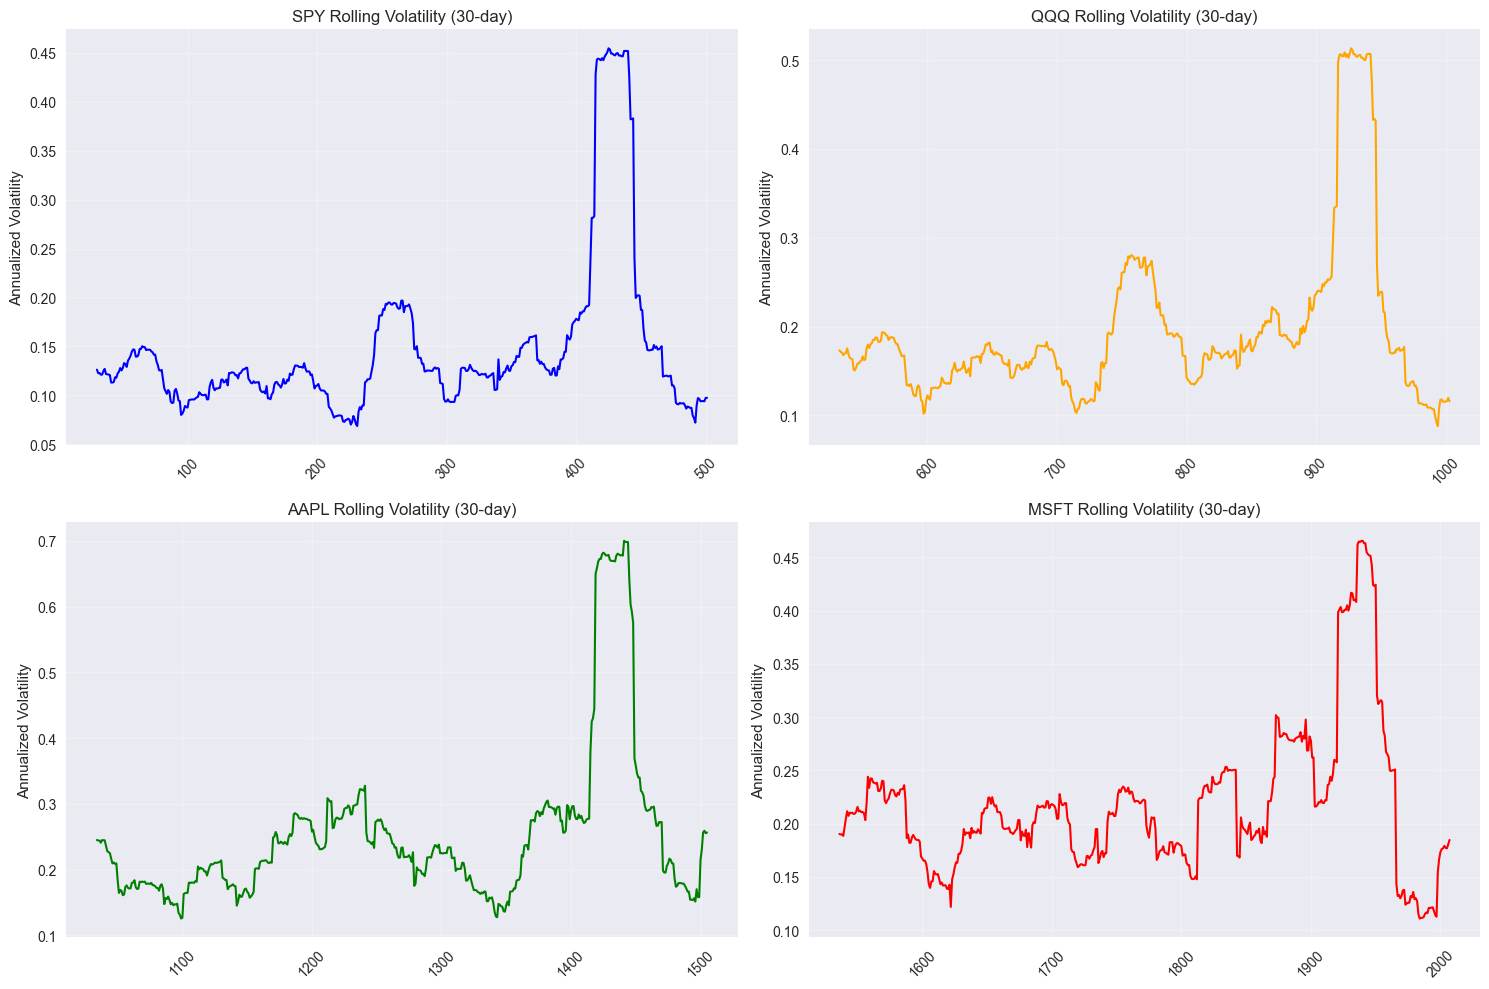

In [21]:
# Calculate rolling volatility
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, symbol in enumerate(symbols):
    symbol_data = data[data["symbol"] == symbol].copy()
    returns = symbol_data["close"].pct_change().dropna()

    # 30-day rolling volatility
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)

    axes[i].plot(rolling_vol.index, rolling_vol, color=colors[i], linewidth=1.5)
    axes[i].set_title(f"{symbol} Rolling Volatility (30-day)")
    axes[i].set_ylabel("Annualized Volatility")
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## 7. Data Preprocessing Pipeline

In [22]:
# Test the preprocessing pipeline
preprocessor = StockPreprocessor(sequence_length=config.sequence_length)

# Prepare data
data_dict = preprocessor.prepare_data(
    data, test_size=config.test_size, validation_size=config.validation_size
)

print(f"Input features: {data_dict['input_size']}")
print(f"Training sequences: {data_dict['X_train'].shape}")
print(f"Validation sequences: {data_dict['X_val'].shape}")
print(f"Test sequences: {data_dict['X_test'].shape}")
print(f"\nFeature columns ({len(data_dict['feature_columns'])}):")
for i, feature in enumerate(data_dict["feature_columns"][:10]):
    print(f"  {i}: {feature}")

Using stock-aware processing (stock-specific scaling + stock-aware batching)
Processing SPY: 502 data points
Created 452 sequences with 6 features
Created 452 sequences for SPY

Processing QQQ: 502 data points
Created 452 sequences with 6 features
Created 452 sequences for QQQ

Processing AAPL: 502 data points
Created 452 sequences with 6 features
Created 452 sequences for AAPL

Processing MSFT: 502 data points
Created 452 sequences with 6 features
Created 452 sequences for MSFT

Processing GOOGL: 502 data points
Created 452 sequences with 6 features
Created 452 sequences for GOOGL

Processing TSLA: 502 data points
Created 452 sequences with 6 features
Created 452 sequences for TSLA

Data split - Train: 1898, Val: 407, Test: 407
Input features: 6
Training sequences: (1898, 50, 6)
Validation sequences: (407, 50, 6)
Test sequences: (407, 50, 6)

Feature columns (6):
  0: open
  1: high
  2: low
  3: volume
  4: dividends
  5: stock splits


## 8. Sequence Analysis

Sample sequence shape: (50, 6)
Sample target: -0.3752


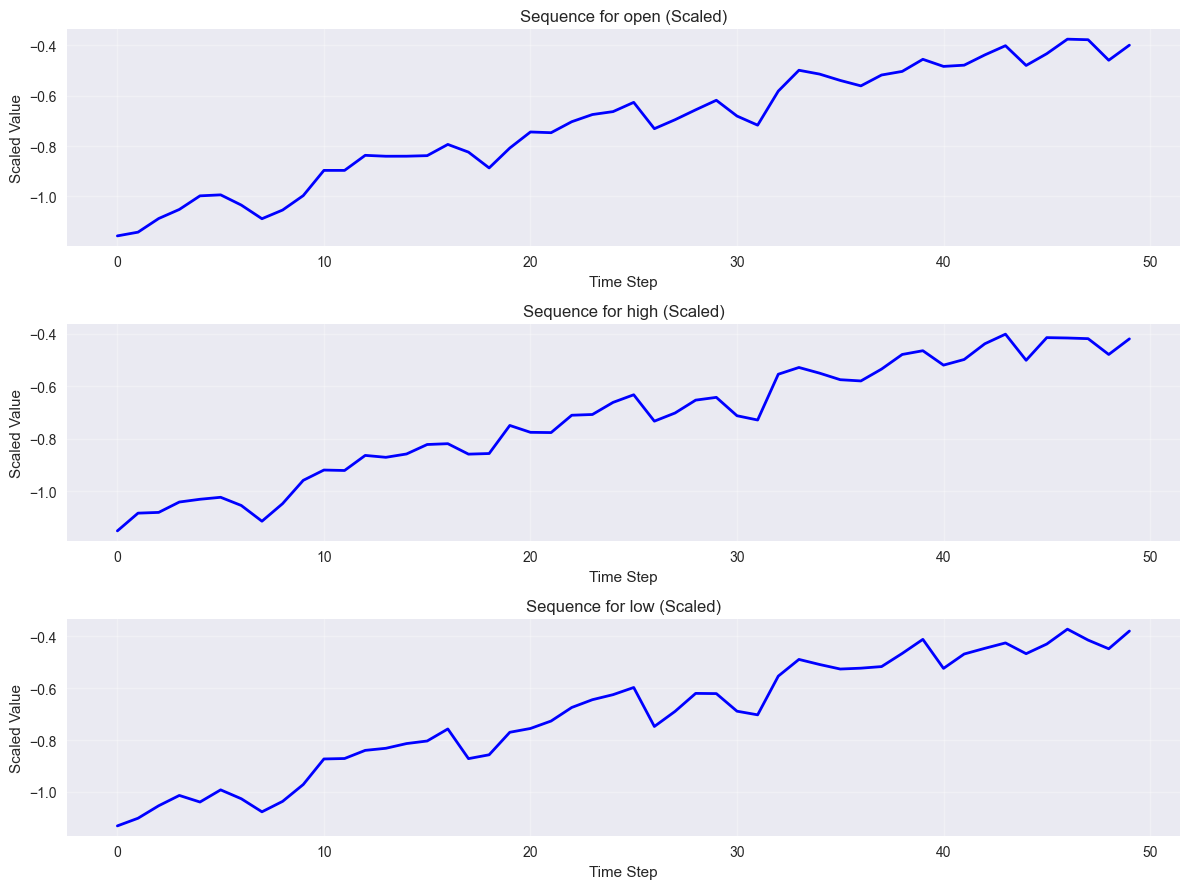

In [23]:
# Visualize a sample sequence
sample_idx = 100
sample_sequence = data_dict["X_train"][sample_idx]  # Shape: (sequence_length, features)
sample_target = data_dict["y_train"][sample_idx]

print(f"Sample sequence shape: {sample_sequence.shape}")
print(f"Sample target: {sample_target[0]:.4f}")

# Plot the sequence for key features
key_features = ["open", "high", "low"]
feature_indices = [
    data_dict["feature_columns"].index(feat)
    for feat in key_features
    if feat in data_dict["feature_columns"]
]

fig, axes = plt.subplots(
    len(feature_indices), 1, figsize=(12, 3 * len(feature_indices))
)
if len(feature_indices) == 1:
    axes = [axes]

for i, feat_idx in enumerate(feature_indices):
    feature_name = data_dict["feature_columns"][feat_idx]
    sequence_values = sample_sequence[:, feat_idx]

    axes[i].plot(range(len(sequence_values)), sequence_values, "b-", linewidth=2)
    axes[i].set_title(f"Sequence for {feature_name} (Scaled)")
    axes[i].set_xlabel("Time Step")
    axes[i].set_ylabel("Scaled Value")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Target Distribution Analysis

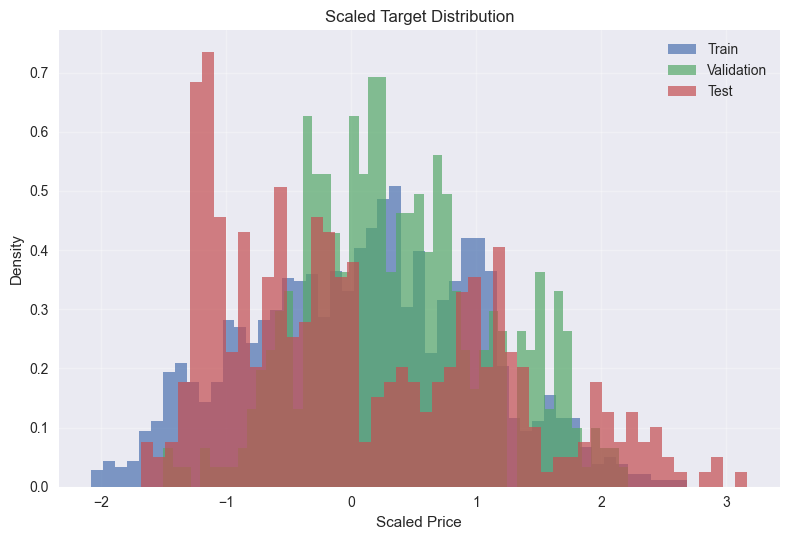

In [24]:
# Analyze target distribution
fig, ax = plt.subplots(1, 1)

# Original targets (scaled)
train_targets = data_dict["y_train"].flatten()
val_targets = data_dict["y_val"].flatten()
test_targets = data_dict["y_test"].flatten()

ax.hist(train_targets, bins=50, alpha=0.7, label="Train", density=True)
ax.hist(val_targets, bins=50, alpha=0.7, label="Validation", density=True)
ax.hist(test_targets, bins=50, alpha=0.7, label="Test", density=True)
ax.set_title("Scaled Target Distribution")
ax.set_xlabel("Scaled Price")
ax.set_ylabel("Density")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()